In [1]:
import h5py
import numpy as np
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas

In [2]:
def def_cmap(color):
    colors = ["white", color]
    n_bins = 100
    cmap_name = "cmap"
    self_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return self_cmap

In [3]:
def def_cmap_2(color):
    colors = ["orange", color]
    n_bins = 100
    cmap_name = "cmap"
    self_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return self_cmap

In [4]:
with h5py.File("averaging_test/U_avg.h5", "r") as file:
    U = file["matrix"][:]

with h5py.File("averaging_test/V_avg.h5", "r") as file:
    V = file["matrix"][:]

with h5py.File("averaging_test/M_avg.h5", "r") as file:
    M = file["matrix"][:]
    
with h5py.File("averaging_test/xgrid_matrix", "r") as file:
    xgrid = file["matrix"][:]
    
with h5py.File("averaging_test/ygrid_matrix", "r") as file:
    ygrid = file["matrix"][:]

# Replace nan in U and V into zeros.
U = np.nan_to_num(U) # (#step, 63, 53) dimensional numpy array.
V = np.nan_to_num(V)

In [5]:
def decode(elem):
    return elem.decode("UTF-8")

with h5py.File("start_points.h5", "r") as file:
    track_id = (list(map(decode, file["track_id"][:])))
    start_x_cor = file["start_x"][:] # List of 1 element lists
    start_y_cor = file["start_y"][:] # List of 1 element lists
    start_t = file["t_interval"][:]  # List of 2 element lists

In [6]:
def get_window_avg(ar, W, i, j):
    # For a given 2D numpy array "ar" extract at the index i,j the subarray with size W = (a, b).
    # Finally return the mean value of the window. 
    # Out of boundary regions are filled by 0.
    h0,h1 = (W[0]-1)//2, (W[1]-1)//2 
    ar_ext = np.pad(ar,((h0,h0),(h1,h1)),'constant',constant_values=(0,0))
    window = view_as_windows(ar_ext, (W[0],W[1]))[i,j]
    return np.mean(window)

In [7]:
# def pseudo_tracking_piv_grid_single(U, V, t_interval, start_x, start_y, scale=(1, 1)):
#     # U, V: (#total_time, 63, 63) dimensional
#     # t_interval: [t0, t1] two element list
#     # start_x: [x0] one element list. x, y in vector field grid.
#     # start_y: [y0] one element list
    
#     # start_x and start_y integers inside x and y dimensions.
#     # Firstly using the coordinate of vector field. 
#     x_dim = np.shape(U)[1]
#     y_dim = np.shape(U)[2]

#     t_interval = range(t_interval[0], t_interval[1]+1)
#     num_step = len(t_interval)
    
#     trajectory_x = [start_x[0]]
#     trajectory_y = [start_y[0]]

#     for i in range(1,num_step):
        
#         x_cor = trajectory_x[i-1]
#         y_cor = trajectory_y[i-1]
#         t = t_interval[i]

#         # Determine the vector directions through averaging surrounding neighbours.
#         dx = scale[0] * get_window_avg(V[t-1], (3, 3), x_cor, y_cor) # Indexing in python begins with 0. 
#         #dx = scale[0] * U[t-1][x_cor, y_cor]
#         dy = scale[1] * get_window_avg(U[t-1], (3, 3), x_cor, y_cor)
#         #dy = scale[1] * V[t-1][x_cor, y_cor]

#         # Update of the start positions and round to the nearest integer.
#         update_x_cor = round(x_cor + dx)
#         update_y_cor = round(y_cor + dy)

#         # Stays in the same position if comes to the image boundary. # TODO: Reweite it in a better way! 
#         if update_x_cor < 0 or update_x_cor >= x_dim:
#             trajectory_x.append(trajectory_x[i-1])
#             trajectory_y.append(trajectory_y[i-1])
#             continue
#         elif update_y_cor < 0 or update_y_cor >= y_dim:
#             trajectory_x.append(trajectory_x[i-1])
#             trajectory_y.append(trajectory_y[i-1])
#             continue
            
#         trajectory_x.append(update_x_cor)
#         trajectory_y.append(update_y_cor)

#     return np.array(trajectory_x), np.array(trajectory_y)

In [8]:
# def pseudo_tracking_piv_grid(U, V, t_interval_array, start_x_array, start_y_array, scale=(1, 1)):
#     # t_interval_array: [[t0, t1], ...] list of two element lists
#     # start_x_array: [[x0], ...] list of one element lists, image coordinates.
#     # start_y_array: [[y0], ...] list of one element lists, image coordinates.
#     all_x_trajectory = []
#     all_y_trajectory = []

#     for i in range(len(start_x_array)):
#         # Transform the x and y in image coordinates into vector field grid.
#         start_x = [round(start_x_array[i][0]/16) - 1]
#         start_y = [round(start_y_array[i][0]/16) - 1]
#         t_interval = t_interval_array[i]

#         x_track, y_track = pseudo_tracking_piv_grid_single(U, V, t_interval, start_x, start_y, scale)
#         # Get the track results in vector field grid and transform into image coordinate.
#         all_x_trajectory.append((x_track+1) * 16)
#         all_y_trajectory.append((y_track+1) * 16)

#     return all_x_trajectory, all_y_trajectory

In [9]:
def pseudo_tracking_piv_grid_single_v2(U, V, t_interval, start_x, start_y, scale=(1, 1)):
    # U, V: (#total_time, 63, 63) dimensional
    # t_interval: [t0, t1] two element list
    # start_x: [x0] one element list. x, y in image coordinate.
    # start_y: [y0] one element list
    
    # start_x and start_y integers inside x and y dimensions.
    # Firstly using the coordinate of vector field. 
    x_dim = np.shape(U)[1]
    y_dim = np.shape(U)[2]

    t_interval = range(t_interval[0], t_interval[1]+1)
    num_step = len(t_interval)
    
    trajectory_x = [start_x[0]] # starting points in image coordinates.
    trajectory_y = [start_y[0]]

    for i in range(1,num_step):
        # Transform the points into vector field grid. 
        x_cor = round(trajectory_x[i-1]/16 - 1)
        y_cor = round(trajectory_y[i-1]/16 - 1)
        t = t_interval[i]
        
        # Determine the vector directions through averaging surrounding neighbours.
        # dx and dy are changes in img coordinates!
        dx = scale[0] * get_window_avg(V[t-1], (3, 3), x_cor, y_cor) # Indexing in python begins with 0. 
        dy = scale[1] * get_window_avg(U[t-1], (3, 3), x_cor, y_cor)

        # Update of the start positions in image coordinate. --> final updated position in img coordinate.
        # If necessary can be round to the nearest integer. As written in outcommented code.
        update_x_img = trajectory_x[i-1] + dx # round(trajectory_x[i-1] + dx)
        update_y_img = trajectory_y[i-1] + dy # round(trajectory_y[i-1] + dy)

        # Tranform the updates position in 
        update_x_grid = round(update_x_img/16 - 1)
        update_y_grid = round(update_y_img/16 - 1)

        # Stays in the last inside position if comes over the image boundary. # TODO: Reweite it in a better way! 
        if update_x_grid < 0 or update_x_grid >= x_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue
        elif update_y_grid < 0 or update_y_grid >= y_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue

        trajectory_x.append(update_x_img)
        trajectory_y.append(update_y_img)

    return np.array(trajectory_x), np.array(trajectory_y) # Final results in image coordinate.

In [10]:
def pseudo_tracking_piv_grid_v2(U, V, t_interval_array, start_x_array, start_y_array, scale=(1, 1)):
    # t_interval_array: [[t0, t1], ...] list of two element lists
    # start_x_array: [[x0], ...] list of one element lists, image coordinates.
    # start_y_array: [[y0], ...] list of one element lists, image coordinates.
    all_x_trajectory = []
    all_y_trajectory = []

    for i in range(len(start_x_array)):
        # Transform the x and y in image coordinates into vector field grid.
        start_x = start_x_array[i]
        start_y = start_y_array[i]
        t_interval = t_interval_array[i]

        x_track, y_track = pseudo_tracking_piv_grid_single_v2(U, V, t_interval, start_x, start_y, scale)
        # Get the track results in vector field grid and transform into image coordinate.
        all_x_trajectory.append(x_track)
        all_y_trajectory.append(y_track)

    return all_x_trajectory, all_y_trajectory


In [11]:
# Plot the pseudo track results
def plot_pseudo_track(track_id, x_track, y_track, t_track, fig_size):
    plt.style.use('dark_background')
    colors = list(mcolors.CSS4_COLORS.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(len(track_id)):
        
        x_cor = x_track[i]
        y_cor = y_track[i]
        t_interval = range(t_track[i][0], t_track[i][-1]+1)
        
        plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
        cmap = def_cmap(colors[i])
        plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
        plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])
    
    plt.xlim(0, fig_size)
    plt.ylim(0, fig_size)
    plt.gca().invert_yaxis()
    #plt.savefig("pseudotrack_img_cor", dpi=300)
    plt.show()

In [12]:
# all_x_track, all_y_track = pseudo_tracking_piv_grid(U, V, start_t, start_x_cor, start_y_cor, (0.8, 1))
# plot_pseudo_track(track_id, all_x_track, all_y_track, start_t, 1024)

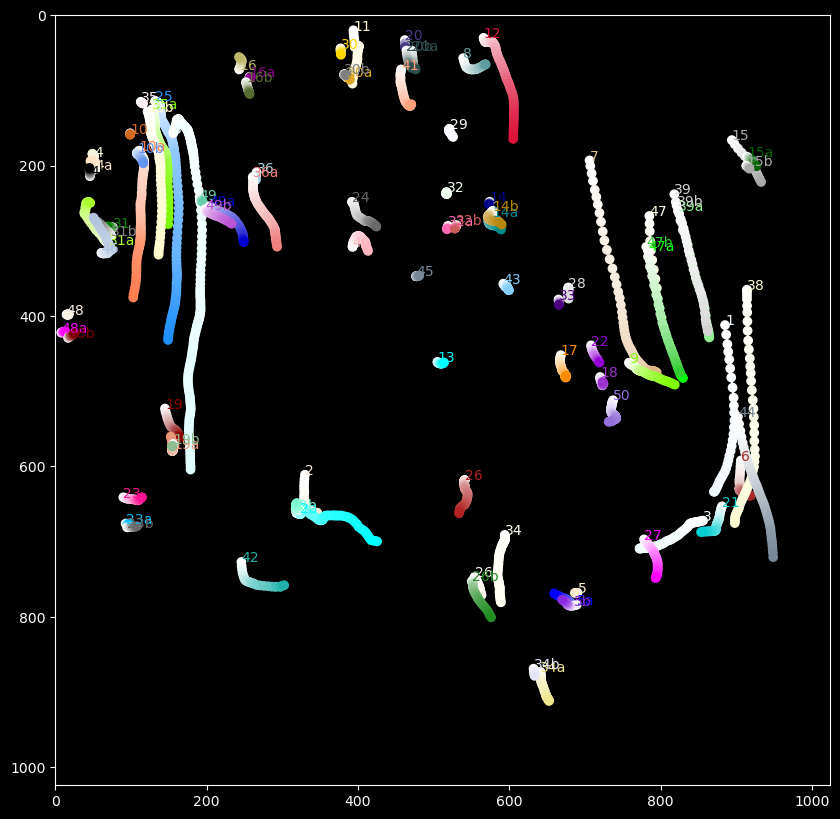

In [13]:
piv_x_track_v2, piv_y_track_v2 = pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor, (3, 3))
plot_pseudo_track(track_id,piv_x_track_v2, piv_y_track_v2, start_t, 1024)

## Comparison with original track

In [14]:
# Original tracking data.
track_csv = pandas.read_csv("F:/PhD_Franziska/Headon/Headon_results/v1_slice3/video1_tracking_cleaned.csv")

In [15]:
# Extract certain tracks with given track_ids
def original_track(track_id, track_csv):
    original_x_track = []
    original_y_track = []
    original_t_track = []
    
    for i in track_id:
        o_x = track_csv.loc[track_csv["Track"]==str(i)]["X"].tolist()
        o_y = track_csv.loc[track_csv["Track"]==str(i)]["Y"].tolist()
        o_t = track_csv.loc[track_csv["Track"]==str(i)]["Frame"].tolist()
        original_x_track.append(o_x)
        original_y_track.append(o_y)
        original_t_track.append(o_t)
    return original_x_track, original_y_track, original_t_track

In [16]:
original_x_track, original_y_track, original_t_track = original_track(track_id, track_csv)

### Statistics of error

In [17]:
def track_dist(original_x, original_y, piv_x, piv_y):
    # Given lists or np.array.
    # Some original data has non continuous time step... --> less time step as it should be.
    if len(original_x) < len(piv_x):
        len_diff = len(piv_x) - len(original_x)
        original_x = np.concatenate([original_x, np.full(len_diff, original_x[-1])])
        original_y = np.concatenate([original_y, np.full(len_diff, original_y[-1])])

    # Map x and y coordinates into 2D points in an array.
    original_pair = np.dstack((original_x, original_y))
    piv_pair = np.dstack((piv_x, piv_y))

    # Calculate the distance between original pair and pic pair for each time step.
    dist = np.linalg.norm(original_pair - piv_pair, axis=2)[0]
    return dist

In [18]:
def track_error(track_id, original_x, original_y, piv_x, piv_y):
    # Generate for all tracks the difference to original tracking data.
    all_dist = []
    for i in range(len(track_id)):
        
        orig_x = original_x[i]
        orig_y = original_y[i]

        pseudo_x = piv_x[i]
        pseudo_y = piv_y[i]

        all_dist.append(track_dist(orig_x, orig_y, pseudo_x, pseudo_y))

    return all_dist

In [19]:
def error_time_step(track_id, original_x, original_y, piv_x, piv_y):
    # Generate firstly all track errors/difference.
    all_track_error = track_error(track_id, original_x, original_y, piv_x, piv_y)

    # Get the elements columnwise and fill the non-exist time steps with nan.  
    # Fill all track step witdth with nan to the maximal length. 
    max_len = max(len(l) for l in all_track_error)
    # Correct the length of original tracking data.
    for i in range(len(track_id)): 
        error = all_track_error[i]
        num_nan = max_len - len(error)
        all_track_error[i] = np.concatenate([error, np.full(num_nan, np.nan)])
        
    all_track_error = np.array(all_track_error)
    # Each coloum are errors in the same time step.
    time_error = []
    mean_time_error = []
    for j in range(max_len):
        error = all_track_error[:, j] # Extract the colums --> all errors at the same time step.
        error_clean = error[~np.isnan(error)] # Get rid of the nan in coloums.
        time_error.append(error_clean)
        mean_time_error.append(np.mean(error_clean))
        
    return time_error, mean_time_error


In [20]:
def plot_time_error(track_id, original_x_track, original_y_track, piv_x_track, piv_y_track,
                   fig_name): # Generate the box plot of distance between original tracks and pseudo tracks vs.frame.
    
    # Generate the data of distance between pseudo tracks and original tracks in dependence of frame.
    time_error, mean_time_error = error_time_step(track_id, original_x_track, 
                                                  original_y_track, piv_x_track, piv_y_track,)
    positions = [i for i in range(1, len(mean_time_error)+1)]
    # Plot
    plt.style.use('default')
    plt.figure(figsize=(30, 10))
    plt.boxplot(time_error)
    plt.scatter(positions, mean_time_error)
    plt.xticks(np.arange(0, len(mean_time_error), step=10), np.arange(0, len(mean_time_error), step=10), fontsize=20)
    plt.yticks(np.arange(0, 351, step=50), np.arange(0, 351, step=50),fontsize=20)
    plt.xlabel("frame", fontsize=25)
    plt.ylabel("distance in pixel", fontsize=25)
    plt.savefig(fig_name, dpi=300) # fig_name a string.
    plt.show()

## Find out the tracks that are in the region with mostly periderm and therefore better results.
Doing the error statistics only in this region.

In [21]:
def extract_index(track_id, start_x_cor, start_y_cor):
    track_index = []
    for i in range(len(track_id)):
        # Find out the tracks with starting points in certain regions. 
        if start_x_cor[i][0] < 300 and start_y_cor[i][0] < 300:
            track_index.append(i)
        elif start_x_cor[i][0] > 600 and start_y_cor[i][0] < 600:
            track_index.append(i)
    return track_index

In [22]:
def extract_cor(track_id, start_x_cor, start_y_cor, original_x_track, 
                original_y_track, pseudo_x_track, pseudo_y_track):
    # Get the index of tracks that are chosen in function extract_index.
    track_index = extract_index(track_id, start_x_cor, start_y_cor)
    
    extract_origi_x = []
    extract_origi_y = []
    
    extract_pseudo_x = []
    extract_pseudo_y = []

    for i in track_index:
        extract_origi_x.append(np.array(original_x_track[i]))
        extract_origi_y.append(np.array(original_y_track[i]))
        
        extract_pseudo_x.append(pseudo_x_track[i])
        extract_pseudo_y.append(pseudo_y_track[i])

    return extract_origi_x, extract_origi_y, extract_pseudo_x, extract_pseudo_y, track_index

# Determine the optimal scaling factor for pseudo tracks.
Based on the length of straight line between start and end points of the track. The optimal scaling factor should scale the pseudo track such that the direct distance between start points and end points to be the same as original tracks.

In [23]:
pseudo_track_x_1, pseudo_track_y_1 = pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor, (1, 1))

In [24]:
def optimal_scale_factor(track_id, start_x_cor, start_y_cor, original_x_track, 
                        original_y_track, pseudo_x_track, pseudo_y_track): 
    # Calculate the factors between length of original tracks and pseudo tracks.
    # Length is the direct distance between start points and end poinst.

    # Extract the tracts in chosen regions.
    extract_origi_x, extract_origi_y, extract_pseudo_x, extract_pseudo_y, track_index = extract_cor(track_id, 
                                                                                                    start_x_cor, 
                                                                                                    start_y_cor, 
                                                                                                    original_x_track, 
                                                                                                    original_y_track, 
                                                                                                    pseudo_x_track, 
                                                                                                    pseudo_y_track)
    scale_factor = []
    index = []

    for i in range(len(track_index)): 
        # The distance between start point and end point in original tracks.
        original_start_pair = np.array([extract_origi_x[i][0], extract_origi_y[i][0]])
        original_end_pair = np.array([extract_origi_x[i][-1], extract_origi_y[i][-1]])
        original_dist = np.linalg.norm(original_start_pair - original_end_pair)

        # Distance between start points and end points in pseudo tracks.
        pseudo_start_pair = np.array([extract_pseudo_x[i][0], extract_pseudo_y[i][0]])
        pseudo_end_pair = np.array([extract_pseudo_x[i][-1], extract_pseudo_y[i][-1]])
        pseudo_dist = np.linalg.norm(pseudo_start_pair - pseudo_end_pair)

        # pseudo tracks underestimate the velocity.
        factor = original_dist/pseudo_dist
        # Avoid influence from extrem large error tracks.
        if factor < 10:
            scale_factor.append(factor)
            index.append(track_index[i])
        # Reduce the influence of extreme values (since could still be some with large error in the selected regions)
        # Choose median to determine the optimal scaling factor for pseudo tracks. 
        
    return np.median(scale_factor), scale_factor, index

In [25]:
def select_by_index(track_id, index_list, track_x, track_y, track_t):
    # Extract the subset of x and y coordinates based on the given index list.
    sub_id = [track_id[i] for i in index_list]
    sub_x = [track_x[i] for i in index_list]
    sub_y = [track_y[i] for i in index_list]
    sub_t = [track_t[i] for i in index_list]
    return sub_id, sub_x, sub_y, sub_t

In [26]:
# Get the optimal scaling factor.
factor, _, index_list = optimal_scale_factor(track_id, start_x_cor, start_y_cor, original_x_track, 
                        original_y_track, pseudo_track_x_1, pseudo_track_y_1)

# calculate the pseudo tracks with optimal scaling factor.
opti_pseudo_x, opti_pseudo_y = pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor, (factor, factor))

# The subset of original tracks and pseudo tracks with optimal factor.
sub_origi_id, sub_origi_x, sub_origi_y, sub_origi_t = select_by_index(track_id, index_list, 
                                                                      original_x_track, original_y_track,
                                                                      original_t_track)
sub_piv_id, sub_piv_x, sub_piv_y, sub_piv_t = select_by_index(track_id, index_list, 
                                                   opti_pseudo_x, opti_pseudo_y, start_t)

# sub_origi_t has the structure of list containing all time steps. sub_piv_t has only start and end points.
# For easier plotting with original tracks together, convert the time stept from piv into the same form as oiriginal.
def convert_form_piv_time(pseudo_t_array): 
    pseudo_t_array_v2 = []
    for time in pseudo_t_array:
        t = [i for i in range(time[0], time[-1] + 1)]
        pseudo_t_array_v2.append(t)
    return pseudo_t_array_v2

sub_piv_t_v2 = convert_form_piv_time(sub_piv_t)
pseudo_t_v2 = convert_form_piv_time(start_t)
# --> Now sub_origi_t and sub_piv_t_v2 has the same data structure (list of lists with all time steps).

In [27]:
def plot_original_pseudo_overlap(track_index, original_x, original_y, original_t,
                                pseudo_x, pseudo_y, pseudo_t, fig_name):
    # Generate the plot overplaps the original tracks and pseudo tracks. White background. 
    plt.style.use('default')
    colors = list(mcolors.CSS4_COLORS.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(len(track_index)): 
    
        # pseudo tracks. 
        piv_x_cor = pseudo_x[i]
        piv_y_cor = pseudo_y[i]
        piv_t = pseudo_t[i]
    
        # Original tracks.
        origi_x_cor = original_x[i]
        origi_y_cor = original_y[i]
        origi_t = original_t[i]

        c_i = track_index[i]
        #plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
        cmap_piv = def_cmap_2(colors[c_i])
        plt.scatter(piv_x_cor, piv_y_cor, c=piv_t, zorder=2, cmap=cmap_piv)
        #cmap_origi = def_cmap(colors[i])
        plt.scatter(origi_x_cor, origi_y_cor, c="silver", zorder=1)
        
    plt.xlim(0, 1024)
    plt.ylim(0, 1024)
    plt.gca().invert_yaxis()
    # fig_name a string.
    plt.savefig(fig_name, dpi = 300)
    plt.show()

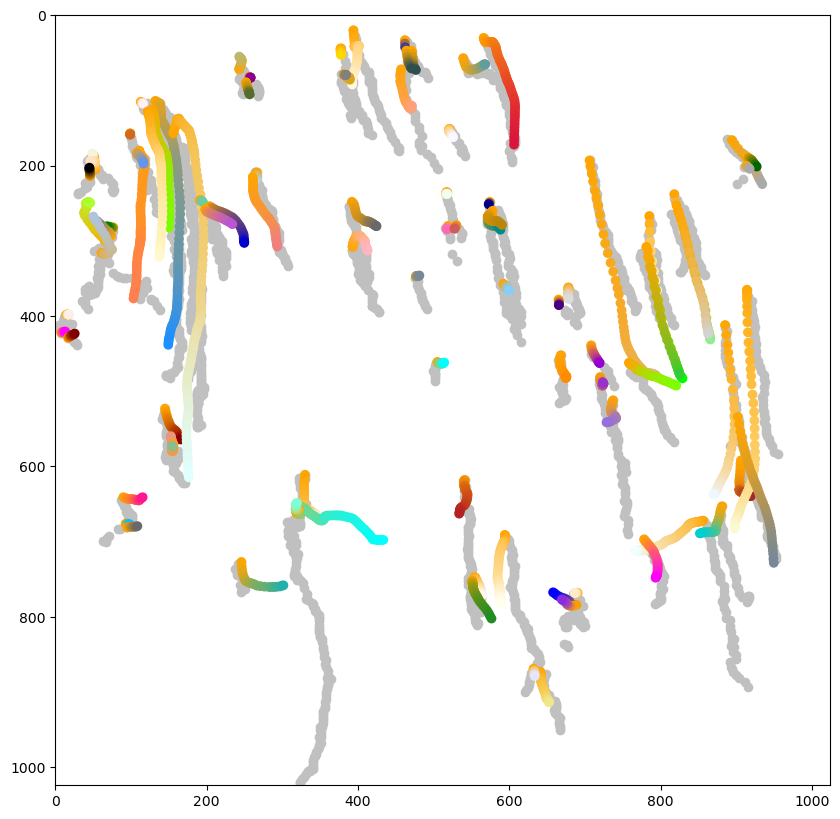

In [28]:
# Figure of all tracks. Pseudo and original tracks are overlapping.
o_index_list = [i for i in range(len(original_x_track))]
plot_original_pseudo_overlap(o_index_list, original_x_track, original_y_track, original_t_track,
                            opti_pseudo_x, opti_pseudo_y, pseudo_t_v2, "overlap_origi_piv_opti_factor")

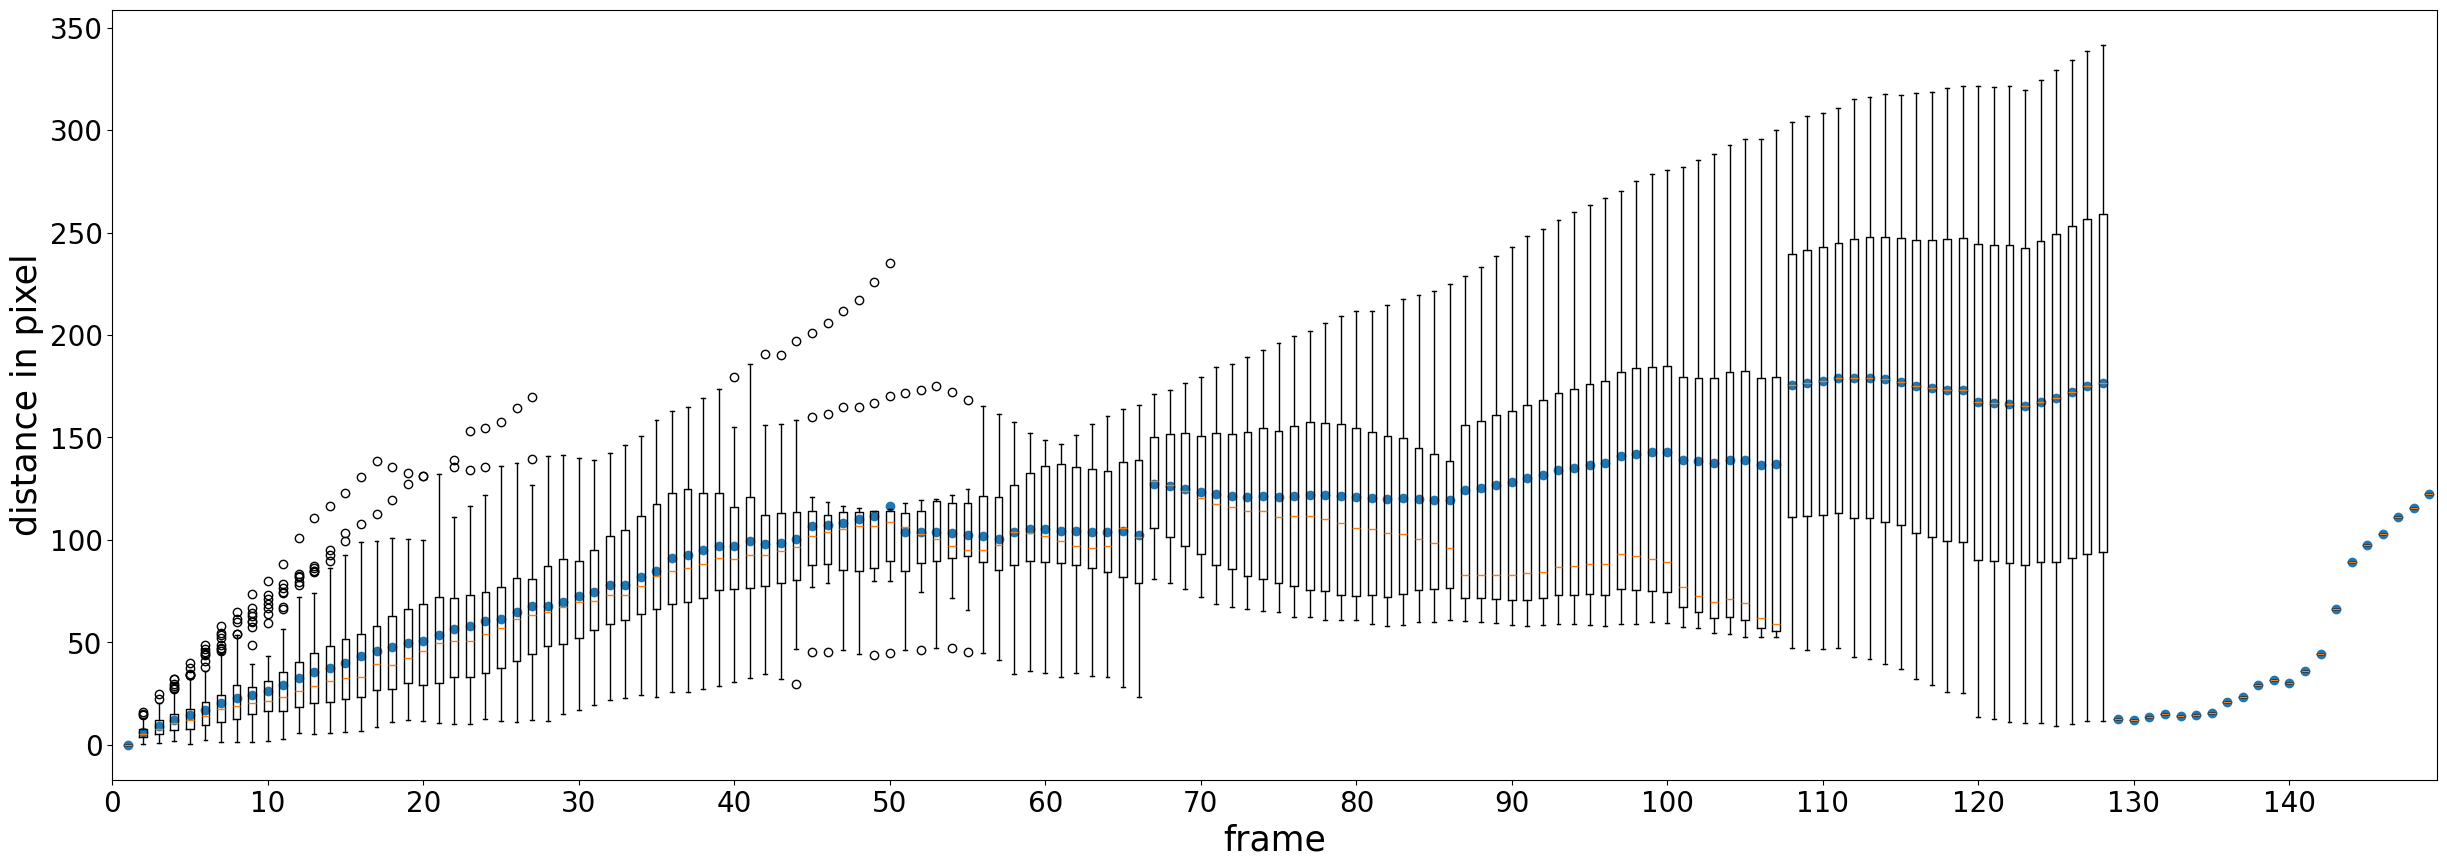

In [29]:
# Figure of time step dependent errors between all original and pseudo tracks.
plot_time_error(track_id, original_x_track, original_y_track, opti_pseudo_x, opti_pseudo_y,
                "time_error_all_tracks")

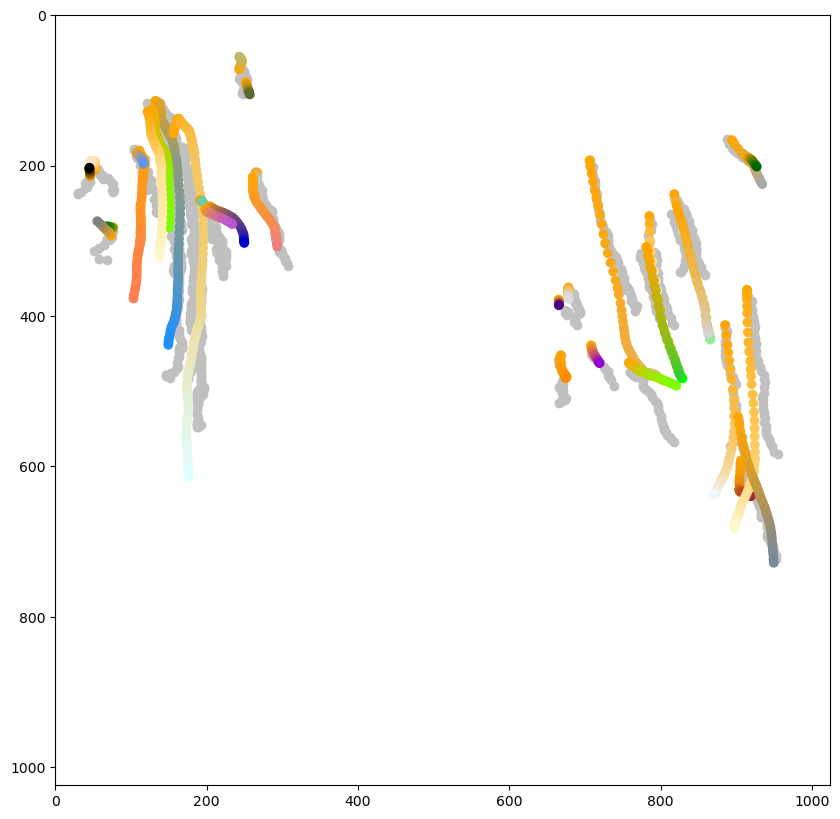

In [30]:
# Figure of tracks in periderm regions. Original and pseudo tracks are overlappeing. 
# Pseudo tracks are generated with the "optimal" scaling factor.
plot_original_pseudo_overlap(index_list, sub_origi_x, sub_origi_y, sub_origi_t,
                            sub_piv_x, sub_piv_y, sub_piv_t_v2, "overlap_origi_piv_opti_factor_subregion")

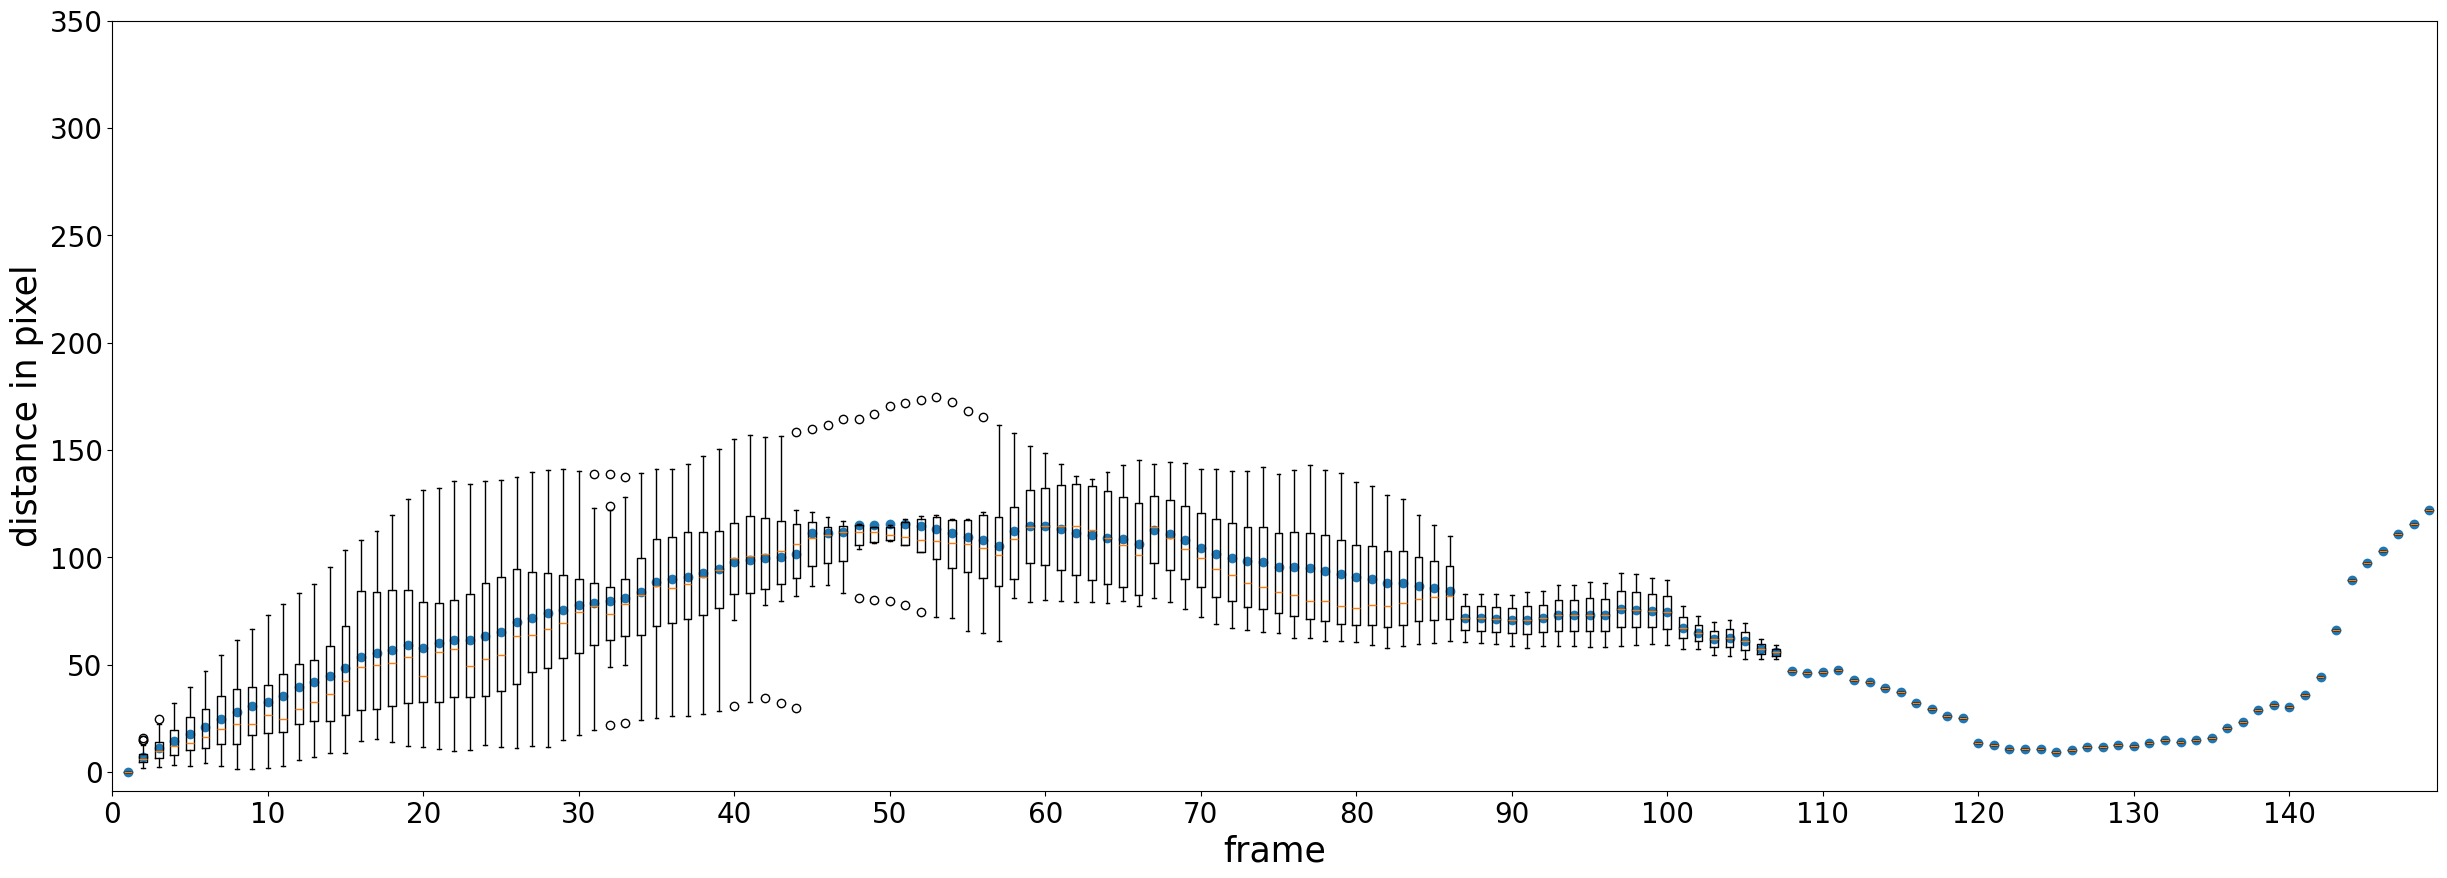

In [31]:
plot_time_error(sub_origi_id, sub_origi_x, sub_origi_y, sub_piv_x, sub_piv_y,
                "time_error_periderm_tracks")

In [32]:
# def select_small_factor_tracks(track_id, original_x, original_y, pseudo_x, pseudo_y, small_factor):
#     # Select out the tracks which has small length difference between original tracks and pseudo tracks.
#     # Get the factor list.
#     scale_factor, _ = optimal_scale_factor(original_x, original_y, pseudo_x, pseudo_y)
#     # Extract the index whose factor is smaller than 4.
#     small_factor_index = [i for i,v in enumerate(scale_factor) if v < small_factor]
#     small_track_id = [track_id[i] for i in small_factor_index]
    
#     return small_factor_index, small_track_id

In [33]:
def plot_original_track(track_id, original_x_track, original_y_track, original_t_track): 
    plt.style.use('dark_background')
    colors = list(mcolors.CSS4_COLORS.keys())

    plt.figure(figsize=(10, 10))
    for i in range(len(track_id)):
        x_cor = original_x_track[i]
        y_cor = original_y_track[i]
        t_interval = original_t_track[i]
        plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
        cmap = def_cmap(colors[i])
        plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
        plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])
    
    plt.xlim(0, 1024)
    plt.ylim(0, 1024)
    plt.gca().invert_yaxis()
    #plt.savefig("all_tracking_video_1_periderm", dpi = 300)
    plt.show()